## Imports

In [21]:
#generic modules
import sys

import sklearn
import matplotlib.pyplot as plt
import mne
from mne import Epochs
from sklearn.metrics import confusion_matrix
import numpy as np
from random import random
import glob
import pandas

from mne import Epochs
from statistics import mean
import pandas as pd

In [22]:
#!pip install mne
import numpy as np
import mne
import pandas as pd
from mne import Epochs, combine_evoked
import os
import json
import sys



## Load Data

In [23]:
src_dir = '/Users/ricksugden/Desktop/EEG_analysis/data/HEROIC/public_software_paper_data/*/remote/*'
src_list = glob.glob(src_dir+'*/')
print('There are '+str(len(src_list))+' files in the dataset')

There are 52 files in the dataset


In [24]:
def find_session(session):
  found_eeg = os.path.exists(session + '/' + 'EEG.csv')
  found_session_info = os.path.exists(session + '/' + 'session_info.json')

  if found_eeg and found_session_info:
    print('Session:\t' + session)
  else:
    print('ERROR: input file(s) not found')
    sys.exit()
  
  session_info = json.load(open(session + '/' + 'session_info.json'))
  print('Description:\t' + session_info['params']['session_type'])
  eeg_device = session_info['params']['eeg_device']
  print('EEG device:\t' + eeg_device)
  
  if not session_info['params']['eeg_device'] in ['Muse 2', 'Muse S']:
    print('ERROR: the data was recorded with ' + session_info['params']['eeg_device'])
    sys.exit()
  markers = session_info['EEG_marks']['EEG_markers']
  markers_stim = [curr for curr in markers if curr['type']=='stimulus']
  
  if len(markers_stim)==0:
    print('ERROR: no stim markers were found')
    sys.exit()
  markers_msg = [x['name'] + '=' + str(x['mark']) for x in markers_stim]
  print('Stim markers:\t' + ', '.join(markers_msg))

  return markers_stim, session_info


In [25]:

def load_data_as_raw(session, channels=['TP9','TP10'],low_freq = 0.5, high_freq=45): 
  # Load data and build basic diagnostic plots
  channels.append('STI')
  fname = os.path.join(session, 'EEG.csv')
  data = pd.read_csv(fname)

  raw_eeg = data.copy()
  raw_eeg *= 1e-6 #convert to uV
  
  if 'timestamps' in raw_eeg.columns:
      del raw_eeg['timestamps']
  if 'marker' in raw_eeg.columns:
      del raw_eeg['marker']

  ch_names = list(raw_eeg.columns)
  raw_eeg = raw_eeg.transpose()
  ch_types = ['eeg'] * 4
  sfreq = 256  # Hz

  # Create the info structure needed by MNE
  info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
  info.set_montage('standard_1020')
  raw = mne.io.RawArray(raw_eeg, info)
  raw.filter(l_freq=low_freq, h_freq=high_freq)
  #raw.plot(scalings=1e-4)
  #raw.plot_psd(average=False)
  info_stim = mne.create_info(['STI'], sfreq, ['stim'])
  data_stim = np.array(data['marker'])
  t = data[['marker']].to_numpy().transpose()
  raw_stim = mne.io.RawArray(t, info_stim)
  raw.add_channels([raw_stim], force_update_info=True)
  events = mne.find_events(raw, stim_channel='STI', shortest_event=0.1)

  raw.pick_channels(channels)

  return raw, events

In [33]:
#@title Aggregate Data Across All Sessions
for i, dir in enumerate(src_list,0):

  if i == 0:
    #use importing_data module to get the events and load the data as a raw object
    markers_stim, session_info = find_session(dir)
    raw, events = load_data_as_raw(dir, channels=['TP9', 'AF7', 'AF8', 'TP10'], low_freq=0.5,  high_freq=45)

  else:
    #use importing_data module to get the events and load the data as a raw object
    markers_stim_append, session_info_append = find_session(dir)
    raw_append, events_append = load_data_as_raw(dir, channels=['TP9', 'AF7', 'AF8', 'TP10'], low_freq=0.5, high_freq=45)
    #raw_append.notch_filter(60, filter_length='auto',phase='zero')

    raw.append(raw_append, preload=True)

  #info_stim = mne.create_info(['STI'], 256, ['stim'])
  print('----------------------finding events------------------')
  events = mne.find_events(raw, stim_channel='STI', shortest_event=1)

Session:	/Users/ricksugden/Desktop/EEG_analysis/data/HEROIC/public_software_paper_data/sub004/remote/20240329-164925_RemoteStudy_Participant/
Description:	home_session
EEG device:	Muse 2
Stim markers:	control=1, oddball=2, closed=3, open=4
Creating RawArray with float64 data, n_channels=4, n_times=124053
    Range : 0 ... 124052 =      0.000 ...   484.578 secs


Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1691 samples (6.605 s)

Creating RawArray with float64 data, n_channels=1, n_times=124053
    Range : 0 ... 124052 =      0.000 ...   484.578 secs
Ready.
261 events found
Event IDs: [   1    2    3    4   70   71   73   84   85   90   91 1072]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
----------------------finding events------------------
261 events found
Event IDs: [   1    2    3    4   70   71   73   84   85 

## Power Band Utils

In [34]:
'''
Iterate over each epoch and extract the Power Band Analysis values
- compute_psd returns the PSD calculated using Welch's method for every channel in the data. The output is in microvolts ^2 / Hz. If the object has multiple epochs, it will perform Welch's FFT separately for each epoch and then average them afterwards.
Source: https://craddm.github.io/eegUtils/reference/compute_psd.html#:~:text=compute_psd%20returns%20the%20PSD%20calculated,in%20microvolts%20%5E2%20%2F%20Hz.
Dictionary Format: { Epoch Number : {Total Power: a, Delta : 0 , Theta : 1, Alpha : 2, Beta : 3, Gamma : 4} , ... }
'''
def get_power_spectral_features(epochs, channel=['TP9']):

  epochs_psd = {}
  for i in range(len(epochs)):
    #print("Epoch", i)

    # Use MULTITAPER, by default, the spectral estimation method will be the Welch[1] method for continuous data, and the multitaper method [2] for epoched or averaged data
    # Change the picked channel here! (ie. 'TP9', 'TP10')
    epochs_in_bin = epochs[i].compute_psd(method='multitaper', fmin=0.5, fmax=45, picks=channel)
   

    iter_freqs = {'Delta': (1, 4), 'Theta': (4, 8), 'Alpha': (8, 14), 'Beta': (14, 30), 'Gamma': (30, 45)}

    # For whole or total brain power to be able to calculate the relative % power!
    psds, freqs = epochs_in_bin.get_data(return_freqs=True, fmin=1, fmax=45)
    
    psd = {}
    psd['Total'] = psds.sum(initial=0)

    # Iterate the fmin and fmax values for the power band frequencies bins and continue for each power band values
    for freq_name in iter_freqs.keys():
      # Get the PSD values for the specific power band
      psds, freqs = epochs_in_bin.get_data(return_freqs=True, fmin=iter_freqs[freq_name][0], fmax=iter_freqs[freq_name][1])
      psd[freq_name] = psds.sum(initial=0)

      # Calculate the relative power for each power band
      psd[freq_name + "Rel"] = psd[freq_name] / psd['Total'] * 100

    epochs_psd[("Epoch " + str(i))] = psd


  return epochs_psd

In [35]:
def get_specific_power_feature(psd, feature=['Alpha']):

  for ii in feature:
    features = []
    
    for i in range(len(psd)):
      feature_to_print = psd.get("Epoch "+ str(i)).get(ii)
      #print(feature_to_print)
      features += [feature_to_print]
  # This function will return the last list of features
  return features

In [36]:
'''
This function will sum the power band values. To be used in cases of considering delta+theta band (1-8 Hz) to that in the alpha+beta band (8-30 Hz) as an indicative of gain (loss) in low (high) frequency power

'''
def sum_power_values(features1, features2):
  if len(features1) != len(features2):
    return None

  sum_features = []
  for (i, j) in zip(features1, features2):
    sum_features += [i + j]

  return sum_features

In [37]:
'''
This function will output the difference of power band values (across epochs). To be used in cases of considering (or normalizing) across electrodes left subtract right, TP9-TP10 and AF7-AF8
'''
def difference_power_values(features1, features2):
 # features_left = get_specific_power_feature(psd_left, ["DeltaRel"])
 # features_right = get_specific_power_feature(psd_right, ["DeltaRel"])
  if len(features1) == len(features2):
    result = []
    for i, j in zip(features1, features2):
     result.append(i - j)
    print(len(result), result)
    return result
  else:
    return "Lengths do not match"

## Perform Power Band Analysis

In [38]:
################################ Epoch the data ################################
#channel = ['TP9']
rejection_thres=None#dict(eeg=100e-6)#uV
time = (-0., 2.0)
baseline= None#(-0.2, 0)

# For the _open_ condition epochs, where Stim markers:	[0] control=1, [1] oddball=2, [2] closed=3, [3] open=4
closed_epochs = Epochs(raw, events, event_id=markers_stim[2]['mark'], tmin=time[0], tmax=time[1], baseline=baseline,reject=rejection_thres, reject_by_annotation=True, preload=True)
open_epochs = Epochs(raw, events, event_id=markers_stim[3]['mark'], tmin=time[0], tmax=time[1], baseline=baseline,reject=rejection_thres, reject_by_annotation=True, preload=True)


Not setting metadata
3096 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 3096 events and 513 original time points ...


0 bad epochs dropped
Not setting metadata
3011 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 3011 events and 513 original time points ...
2 bad epochs dropped


In [39]:
################################ Generate the power bands for each electrode ###################################
psd_ec_tp9 = get_power_spectral_features(closed_epochs, channel=['TP9'])
psd_ec_tp10 = get_power_spectral_features(closed_epochs, channel=['TP10'])
psd_ec_af7 = get_power_spectral_features(closed_epochs, channel=['AF7'])
psd_ec_af8 = get_power_spectral_features(closed_epochs, channel=['AF8'])

psd_eo_tp9 = get_power_spectral_features(open_epochs, channel=['TP9'])
psd_eo_tp10 = get_power_spectral_features(open_epochs, channel=['TP10'])
psd_eo_af7 = get_power_spectral_features(open_epochs, channel=['AF7'])
psd_eo_af8 = get_power_spectral_features(open_epochs, channel=['AF8'])


    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spe

In [40]:
############################################## format the data to compare eyes open and closed ##############################################
psd_list = [psd_ec_af7, psd_ec_af8, psd_ec_tp9, psd_ec_tp10, psd_eo_af7, psd_eo_af8, psd_eo_tp9, psd_eo_tp10]
psd_list_names = ['psd_ec_af7', 'psd_ec_af8', 'psd_ec_tp9', 'psd_ec_tp10','psd_eo_af7', 'psd_eo_af8', 'psd_eo_tp9', 'psd_eo_tp10']

counter = 0
df_list = []

for psd in psd_list:
  print('getting features for ' + psd_list_names[counter])
  delta_features = get_specific_power_feature(psd, ["DeltaRel"])
  theta_features = get_specific_power_feature(psd, ["ThetaRel"])
  alpha_features = get_specific_power_feature(psd, ["AlphaRel"])
  beta_features = get_specific_power_feature(psd, ["BetaRel"])
  gamma_features = get_specific_power_feature(psd, ["GammaRel"])

  df = pd.DataFrame({'delta': delta_features, 'theta': theta_features, 'alpha': alpha_features, 'beta': beta_features, 'gamma': gamma_features})
  #display(df)
  #df.to_csv('./' + psd_list_names[counter] + '.csv')
  df_list.append(df)
  counter += 1

getting features for psd_ec_af7
getting features for psd_ec_af8
getting features for psd_ec_tp9
getting features for psd_ec_tp10
getting features for psd_eo_af7
getting features for psd_eo_af8
getting features for psd_eo_tp9
getting features for psd_eo_tp10


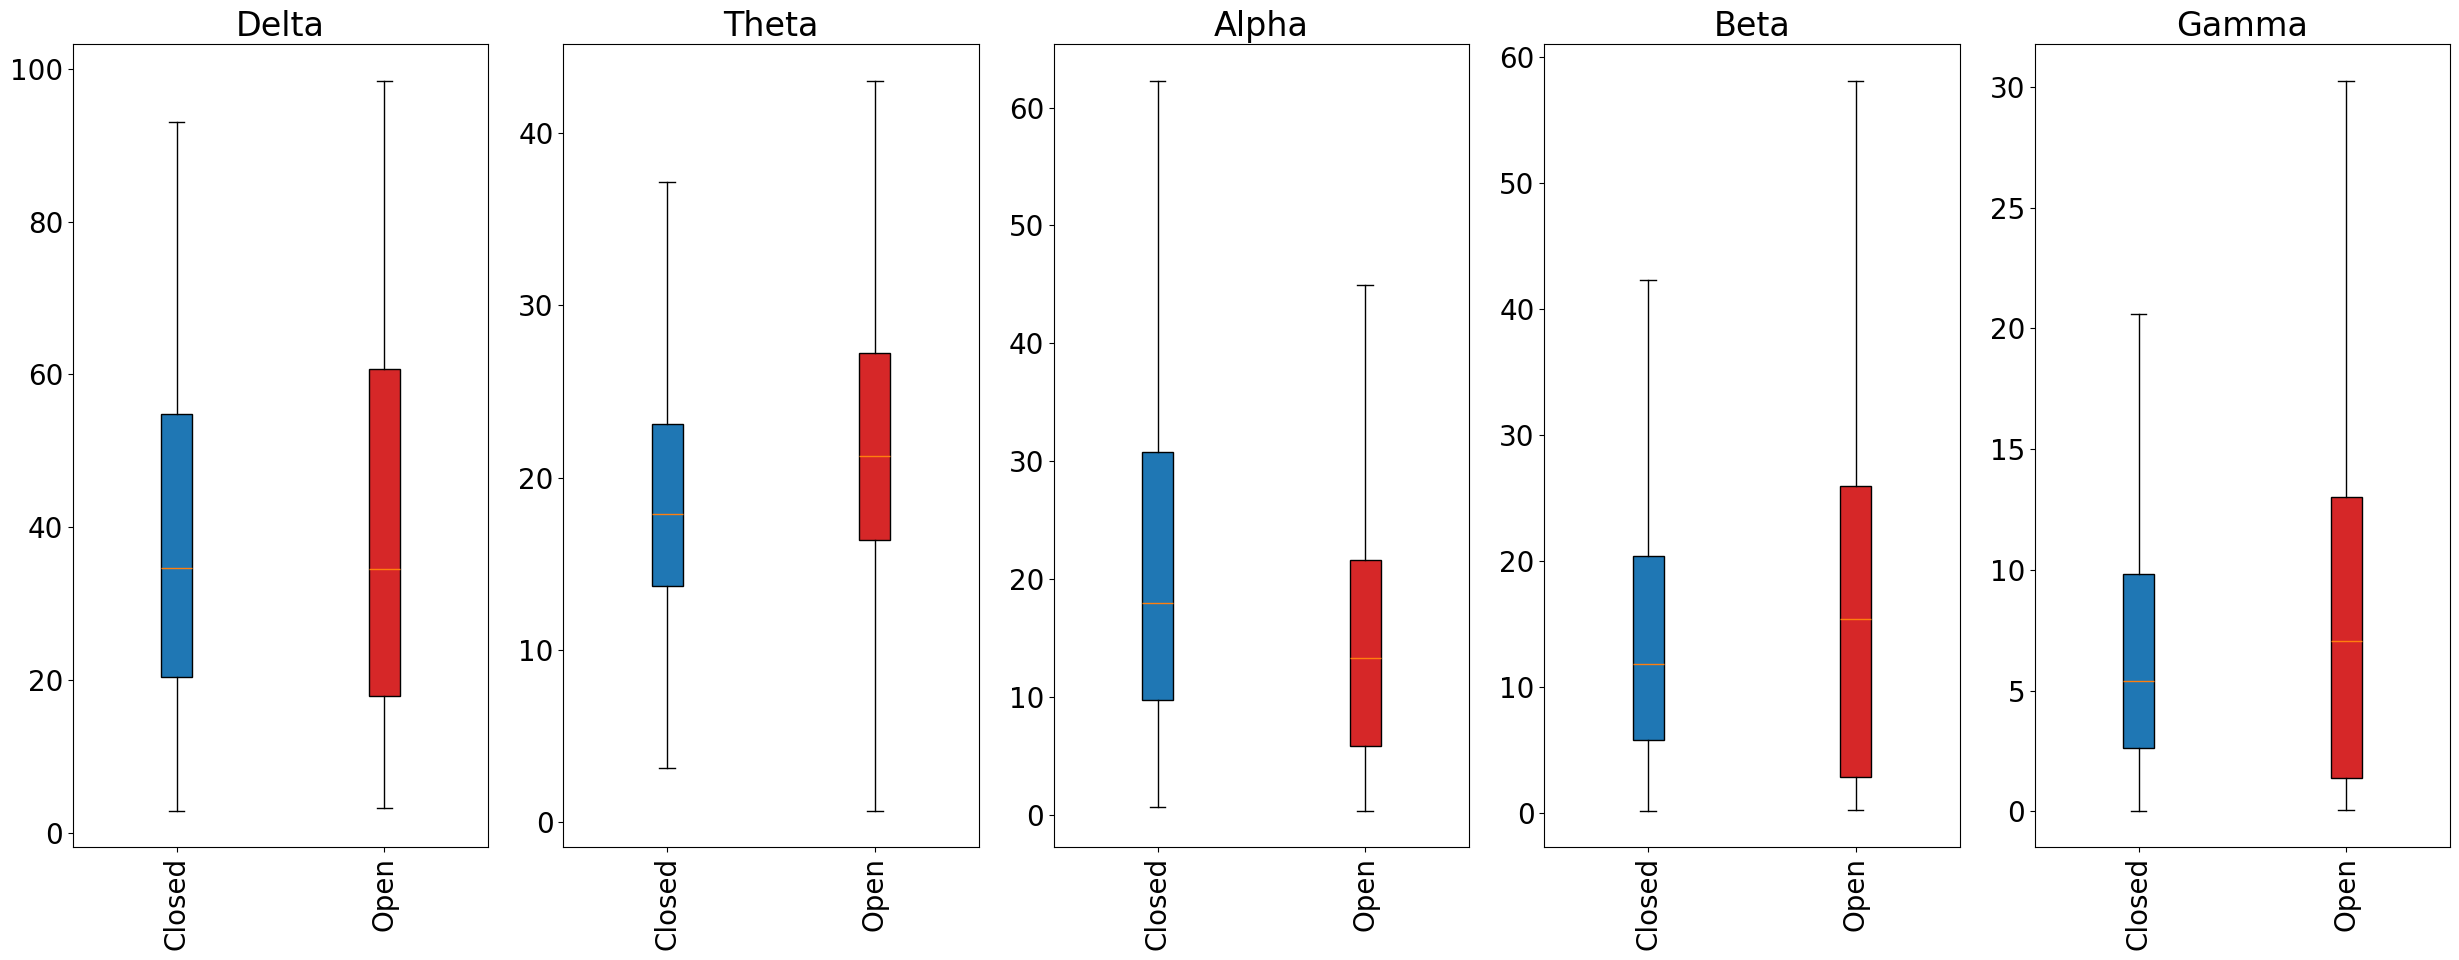

P-values for each frequency band:
Delta: 3.66e-01
Theta: 6.11e-51
Alpha: 1.45e-84
Beta: 3.62e-13
Gamma: 2.52e-08


In [41]:
import matplotlib.pyplot as plt
from scipy import stats

##################################### Choose the Electrode ####################################
# Define the variables
channel = 'TP10' #change this to see other electrodes
index_dict = {'AF7': 0, 'AF8': 1, 'TP9': 2, 'TP10': 3}
p_vals = []
colors = ["#1f77b4", "#d62728"]
###############################################################################################

# Update the plot parameters
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'font.weight': 'normal'})
plt.rcParams.update({'lines.linewidth': 3})

# Create the subplots
fig, axes = plt.subplots(1, 5, figsize=(25, 10))  # Adjusted figsize for better visualization

# Define the frequency bands
bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
titles = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']

for i, band in enumerate(bands):
    df1 = df_list[0 + index_dict[channel]]
    df2 = df_list[4 + index_dict[channel]]
    
    # Create a subplot for each frequency band
    ax = axes[i]
    bp = ax.boxplot([df1[band], df2[band]], showfliers=False, patch_artist=True)
    
    # Apply colors to each box
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['Closed', 'Open'], rotation=90)
    ax.set_title(titles[i])
    
    # Perform t-test
    t_stat, p_value = stats.ttest_ind(df1[band], df2[band])
    p_vals.append(p_value)

# Display the plot
plt.tight_layout()
plt.show()

# Print the p-values for reference
bands = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
print("P-values for each frequency band:")
for band, p_value in zip(bands, p_vals):
    print(f"{band}: {p_value:.2e}")

